<a href="https://colab.research.google.com/github/muhammadelfikry/Emotion-Prediction/blob/development/Emotion_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
df = pd.read_csv("/content/Emotion_final.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


In [11]:
# melakukan proses one-hot-encoding dan membuat dataframe baru
category = pd.get_dummies(df.Emotion)
new_df = pd.concat([df, category], axis=1)
new_df = new_df.drop(columns='Emotion')
new_df

,Text,anger,fear,happy,love,sadness,surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0
...,...,...,...,...,...,...,...
21454,Melissa stared at her friend in dism,0,1,0,0,0,0
21455,Successive state elections have seen the gover...,0,1,0,0,0,0
21456,Vincent was irritated but not dismay,0,1,0,0,0,0
21457,Kendall-Hume turned back to face the dismayed ...,0,1,0,0,0,0


In [12]:
# mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array 
text = new_df["Text"].values
label = new_df[["anger", "fear", "happy", "love", "sadness", "surprise"]].values

# membagi data set menjadi train dan test set
text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.2)

In [14]:
# proses tokenizer
filt = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>", filters=filt)
tokenizer.fit_on_texts(text_train)

# Menyimpan word_index kedalam sebuah file json
word_index = tokenizer.word_index
 
with open('word_index.json', 'w') as fp:
    json.dump(word_index, fp)


# mengubah kalimat ke dalam sequence dan melakukan padding
sequence_train = tokenizer.texts_to_sequences(text_train)
sequence_test = tokenizer.texts_to_sequences(text_test)

padded_train = pad_sequences(sequence_train,
                               padding="post",
                               maxlen=45,
                               truncating="post")
padded_test = pad_sequences(sequence_test,
                               padding="post",
                               maxlen=45,
                               truncating="post")

In [15]:
# pembuatan model menggunakan sequential
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.LSTM(64), # penggunaan teknik LSTM
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(6, activation="softmax")
])
     
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0

In [16]:
# memanggil fungsi compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
# membuat callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("accuracy") > 0.9) and (logs.get("val_accuracy") > 0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [18]:
# melatih model 
num_epochs = 30
history = model.fit(padded_train, label_train,
                    batch_size=32, 
                    epochs=num_epochs,
                    validation_data=(padded_test, label_test),
                    callbacks=[callbacks], 
                    verbose=2)

Epoch 1/30
537/537 - 20s - loss: 1.5657 - accuracy: 0.3288 - val_loss: 1.2907 - val_accuracy: 0.4138 - 20s/epoch - 37ms/step
Epoch 2/30
537/537 - 17s - loss: 1.1559 - accuracy: 0.4258 - val_loss: 1.0339 - val_accuracy: 0.4760 - 17s/epoch - 31ms/step
Epoch 3/30
537/537 - 17s - loss: 0.9140 - accuracy: 0.5596 - val_loss: 0.8784 - val_accuracy: 0.6652 - 17s/epoch - 31ms/step
Epoch 4/30
537/537 - 16s - loss: 0.5653 - accuracy: 0.8195 - val_loss: 0.4790 - val_accuracy: 0.8301 - 16s/epoch - 30ms/step
Epoch 5/30
537/537 - 16s - loss: 0.3454 - accuracy: 0.8941 - val_loss: 0.3792 - val_accuracy: 0.8865 - 16s/epoch - 30ms/step
Epoch 6/30
537/537 - 16s - loss: 0.2661 - accuracy: 0.9154 - val_loss: 0.3034 - val_accuracy: 0.8991 - 16s/epoch - 30ms/step
Epoch 7/30

Akurasi telah mencapai >90%!
537/537 - 16s - loss: 0.2174 - accuracy: 0.9284 - val_loss: 0.3219 - val_accuracy: 0.9033 - 16s/epoch - 31ms/step


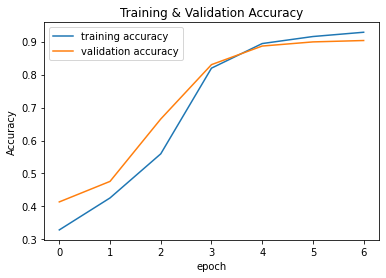

In [19]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(len(acc))

plt.plot(epochs, acc, label="training accuracy")
plt.plot(epochs, val_acc, label="validation accuracy")
plt.title("Training & Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

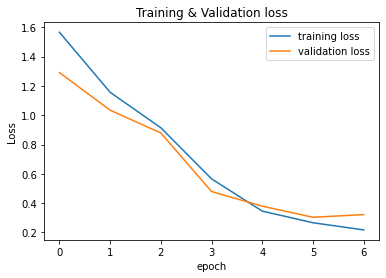

In [20]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))

plt.plot(epochs, loss, label="training loss")
plt.plot(epochs, val_loss, label="validation loss")
plt.title("Training & Validation loss")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

In [21]:
model.save("model.h5")

In [22]:
# Install tensorflowjs
!pip install tensorflowjs
 
# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.4/197.4 KB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━